In [1]:
# Get the parent directory
import sys
import os
import pandas as pd
import yaml
parent_dir = os.path.dirname(os.path.realpath("."))
sys.path.append(parent_dir)
import seaborn as sns
import pickle
from matplotlib import pyplot as plt

In [2]:
from dreamsim import dreamsim
from PIL import Image
import torch

device = "cuda"
model, preprocess = dreamsim(pretrained=True, device=device)

/workspace/ds/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cached ./models


Using cache found in ./models/facebookresearch_dino_main
/workspace/ds/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/workspace/ds/lib/python3.10/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [40]:
!ls /workspace/Diploma/OneActor/experiments/consistory_adventurer/exp_2504242126

base			images		   output_2504242238  target_mask.png
config_2504242126.yaml	inference_sdxl	   output_2504242316  xt_list.pkl
data_list.pkl		output_2504242206  target.jpg


In [41]:
exp_dirs = ['/workspace/Diploma/OneActor/experiments/teenager_wearing_shorts_and_canvas_shoes/exp_2504211015',
 '/workspace/Diploma/OneActor/experiments/young_woman_with_long_wavy_hair/exp_2504220617',
 '/workspace/Diploma/OneActor/experiments/adventurer_with_tousled_hair_comic_book/exp_2504220640']
exp_dirs = ['/workspace/Diploma/OneActor/experiments/consistory_adventurer/exp_2504242126']

In [42]:
res = []
for exp_dir in exp_dirs:
    target_path = f"{exp_dir}/target.jpg"
    for _, dir, _ in os.walk(exp_dir):
        break
    dir = [d for d in dir if 'output' in d]
    for d in dir:
        with open(f"{exp_dir}/{d}/log_train.log", 'r') as config_file:
            config = yaml.safe_load(config_file)
        for _, _, files in os.walk(f"{exp_dir}/{d}/inference"):
            break
        for f in files:
            res.append({
                'thema': exp_dir.split("/")[5],
                'exp': exp_dir.split("/")[6],
                'model': d,
                'config': config,
                'target_img_path': target_path,
                'gen_img_path': f"{exp_dir}/{d}/inference/{f}",
                'prompt':('_'.join(f.split(".")[0].split("_")[:-1])),
                'epoch':0 if f.split(".")[0].split("_")[-1] == 'sdxl' else int(f.split(".")[0].split("_")[-1])
            })
    for _, _, files in os.walk(f"{exp_dir}/inference_sdxl"):
        break
    for f in files:
        res.append({
            'thema': exp_dir.split("/")[5],
            'exp': exp_dir.split("/")[6],
            'model': 'sdxl',
            'config': {},
            'target_img_path': target_path,
            'gen_img_path': f"{exp_dir}/inference_sdxl/{f}",
            'prompt':('_'.join(f.split(".")[0].split("_")[:-1])),
            'epoch':0 if f.split(".")[0].split("_")[-1] == 'sdxl' else int(f.split(".")[0].split("_")[-1])
        })
    

In [43]:
!ls /workspace/Diploma/OneActor/experiments/consistory_adventurer/exp_2504242126

base			images		   output_2504242238  target_mask.png
config_2504242126.yaml	inference_sdxl	   output_2504242316  xt_list.pkl
data_list.pkl		output_2504242206  target.jpg


In [44]:
from torchmetrics.multimodal.clip_score import CLIPScore
import torch
metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16")

In [45]:
metric = metric.to(device)

In [46]:
import numpy as np
from tqdm import tqdm
for n, r in tqdm(enumerate(res)):
    img1 = Image.open(r['target_img_path'])
    img2 = Image.open(r['gen_img_path'])
    img1 = np.array(img1.convert("RGB"))
    img1 = torch.from_numpy(img1).permute(2, 0, 1).to(device)
    img2 = np.array(img2.convert("RGB"))
    img2 = torch.from_numpy(img2).permute(2, 0, 1).to(device)
    clip_score = metric(img1, img2)
    res[n]['CLIPScore'] = clip_score.detach().round().item()

48it [00:04, 11.96it/s]


In [47]:
for n, r in tqdm(enumerate(res)):
    img1 = preprocess(Image.open(r['target_img_path'])).to(device)
    img2 = preprocess(Image.open(r['gen_img_path'])).to(device)
    distance = model(img1, img2)
    res[n]['dreamsim'] = float(distance.cpu().detach().numpy()[0])

48it [00:04, 11.94it/s]


In [48]:
for n, r in enumerate(res):
    if r['config'] == {}:
        title = 'sdxl'
    elif r['config']['use_mask']:
        title = f"mask, p={r['config']['mask_power']}, a={r['config']['mask_alpha']}"
    elif r['config']['use_zone']:
        title = f"zone, a={r['config']['zone_alpha']}"
    else:
        title="OneActor"
    res[n]['title'] = title

KeyError: 'use_mask'

In [49]:
df = pd.DataFrame(res)
df = df[['thema', 'exp', 'model', 'prompt',
       'epoch', 'dreamsim', 'CLIPScore']]
df[df['epoch'] == 200].groupby(['model']).agg({'dreamsim':'mean', 'exp':'count'})
df['dreamsimScore'] = 1 - df['dreamsim']

In [51]:
df_agg=df.groupby(['epoch', 'model']).agg({'dreamsimScore':'mean', 'CLIPScore':'mean', 'exp':'count'}).reset_index()

In [52]:
df_agg['dreamsimScore'].max(), df_agg

(np.float64(0.7305287818113962),
    epoch              model  dreamsimScore  CLIPScore  exp
 0      0               sdxl       0.638830  83.083333   12
 1    200  output_2504242206       0.671086  83.916667   12
 2    200  output_2504242238       0.711523  86.500000   12
 3    200  output_2504242316       0.730529  85.750000   12)

Text(0.5, 1.0, 'CLIPScore, mean')

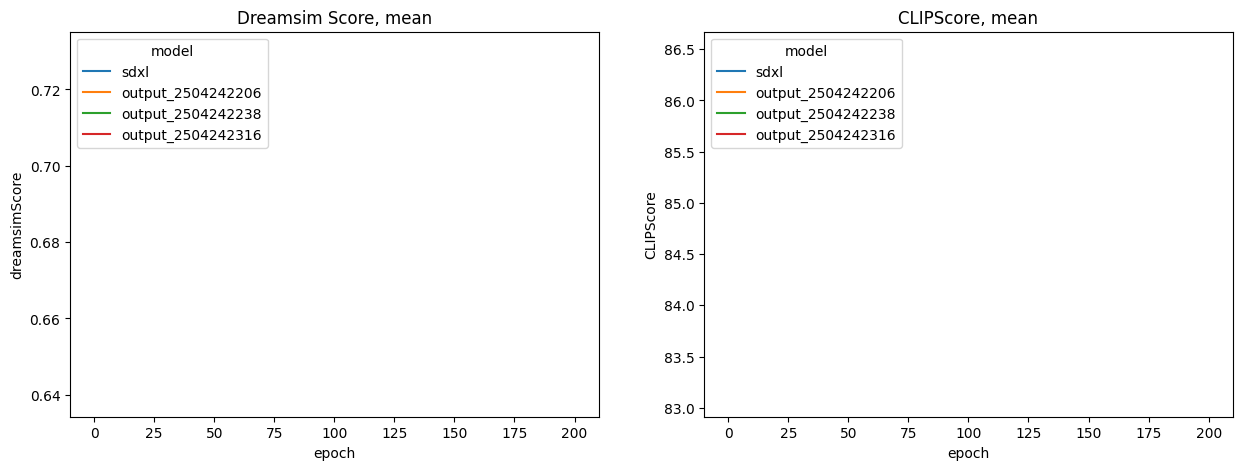

In [53]:
f, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=df_agg, x="epoch", y="dreamsimScore", hue="model",  ax=axes[0])
sns.lineplot(data=df_agg, x="epoch", y="CLIPScore", hue="model",  ax=axes[1])
axes[0].set_title("Dreamsim Score, mean")
axes[1].set_title("CLIPScore, mean")

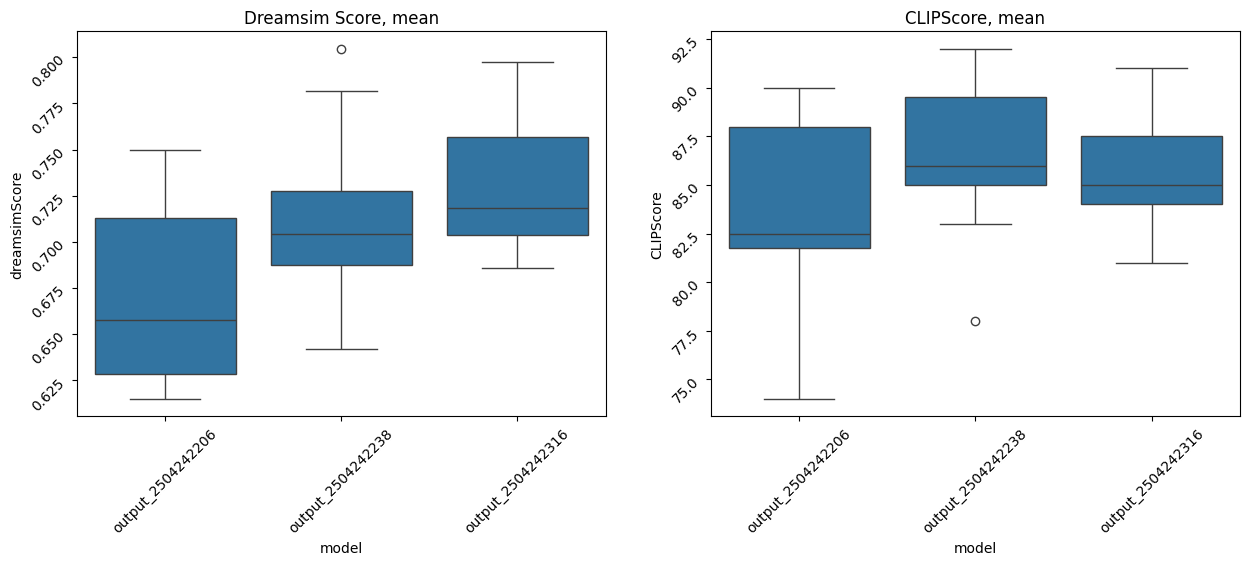

In [54]:
f, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=df[df['epoch'] == 200], x="model", y="dreamsimScore",  ax=axes[0])
sns.boxplot(data=df[df['epoch'] == 200], x="model", y="CLIPScore",  ax=axes[1])
axes[0].set_title("Dreamsim Score, mean")
axes[1].set_title("CLIPScore, mean")
axes[0].tick_params(labelrotation=45)
axes[1].tick_params(labelrotation=45)

In [65]:
for exp_dir in exp_dirs:
    with open(f"{exp_dir}/metric_ds.pickle", 'wb') as handle:
        pickle.dump(df[
                    (df['thema'] == exp_dir.split("/")[5]) & (df['exp'] == exp_dir.split("/")[6])
                    ], handle)

In [66]:
with open(f"metric_ds.pickle", 'wb') as handle:
    pickle.dump(df, handle)

In [55]:
! cp ./ds_metrics.ipynb /workspace/Diploma/notebooks

In [58]:
! cp /workspace/Diploma/notebooks/reconciliation.ipynb /workspace/Diploma/OneActor/experiments/consistory_adventurer/exp_2504242126

In [56]:
for dir in exp_dirs:
    print("!cp /workspace/Diploma/notebooks/reconciliation.ipynb", dir)

!cp /workspace/Diploma/notebooks/reconciliation.ipynb /workspace/Diploma/OneActor/experiments/consistory_adventurer/exp_2504242126


In [31]:
!cp /workspace/Diploma/notebooks/reconciliation.ipynb /workspace/Diploma/OneActor/experiments/teenager_wearing_shorts_and_canvas_shoes/exp_2504211015
!cp /workspace/Diploma/notebooks/reconciliation.ipynb /workspace/Diploma/OneActor/experiments/young_woman_with_long_wavy_hair/exp_2504220617
!cp /workspace/Diploma/notebooks/reconciliation.ipynb /workspace/Diploma/OneActor/experiments/adventurer_with_tousled_hair_comic_book/exp_2504220640